## Neural Networks: Binary Classification

In [317]:
#!pip install torch

Import all the packages we will need

In [318]:
import numpy as np
import pandas as pd
import seaborn as sns # for plotting

# various PyTorch things for NNs
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split, DataLoader

# if you want reproducability, set random seeds:
# np.random.seed(42)
# torch.manual_seed(42)

Load in the dataset and take a glance at it

In [319]:
df = pd.read_csv('topic3-spiral.csv')
df.iloc[:5]

,x,y,arm
0,0.361659,-1.815359,0
1,-0.080207,0.467795,0
2,-1.236511,-0.940904,0
3,-0.568537,0.013438,0
4,-0.004653,-0.019253,0


Plot the data to see what's going on

<Axes: xlabel='x', ylabel='y'>

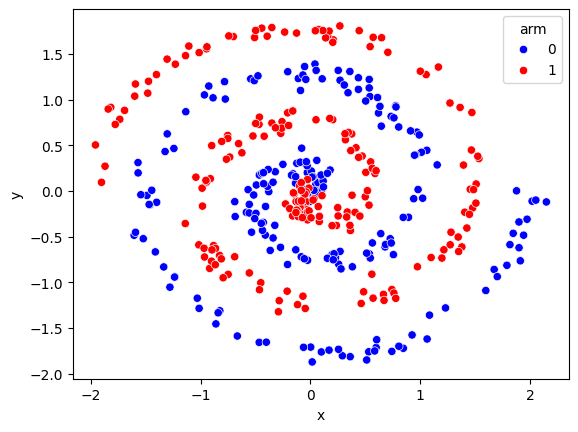

In [320]:
sns.scatterplot(data=df, x='x', y='y', hue='arm', palette={0: "#0000FF", 1: "#FF0000"})

Define the model architecture and instantiate the model

In [321]:
# Define the model architecture
class NNModelAdam(nn.Module):
    def __init__(self, dropout_rate=0):
        super(NNModelAdam, self).__init__()
        self.fc1 = nn.Linear(2, 8) # input has 2 neurons ('x' and 'y'), hidden layer 1 has 8 neurons
        self.fc2 = nn.Linear(8, 8) # hidden layer 1 has 8 neurons, hidden layer 2 has 8 neurons
        self.fc3 = nn.Linear(8, 4) # hidden layer 2 has 8 neurons, hidden layer 3 has 4 neurons
        self.fc4 = nn.Linear(4, 1) # hidden layer 3 has 4 neurons, output layer has 1 neuron (probability)
        self.dropout = nn.Dropout(dropout_rate)  # dropout with the default rate specified above

    def forward(self, x):
        x = F.relu(self.fc1(x)) # use ReLU activation function on hidden layer 1
        x = self.dropout(x) # dropout neurons in hidden layer 1
        x = F.relu(self.fc2(x)) # use ReLU activation function on hidden layer 2
        x = self.dropout(x) # dropout neurons in hidden layer 2
        x = F.relu(self.fc3(x)) # use ReLU activation function on hidden layer 3
        x = self.dropout(x) # dropout neurons in hidden layer 3
        x = torch.sigmoid(self.fc4(x)) # use sigmoid on output layer for binary classification to ensure range is 0 to 1
        return x

# Instantiate the model
model = NNModelAdam()

# Loss function and optimizer
criterion = nn.BCELoss()  # use binary cross-entropy for loss
optimizer = optim.Adam(model.parameters(), lr=0.01) # make updates with a learning rate of 0.01

Prepare the data for training

In [322]:
# Prepare data
X = torch.tensor(np.stack([df['x'], df['y']], axis=1), dtype=torch.float32)
y = torch.tensor(df['arm'].values.reshape(-1, 1), dtype=torch.float32)
dataset = TensorDataset(X, y)

train_ds, val_ds = random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])
train_dl = DataLoader(train_ds, batch_size=50, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=50)

Train the NN model

In [323]:
num_epochs = 100

# Training loop with accuracy
for epoch in range(num_epochs):
    def run_epoch(dataloader, training=True):
        model.train() if training else model.eval()
        total_loss, correct, total_samples = [], 0, 0

        for xb, yb in dataloader:
            preds = model(xb)
            loss = criterion(preds, yb)

            if training:
                optimizer.zero_grad() # set gradients to zero to begin
                loss.backward() # perform backpropogation to set the gradients
                optimizer.step() # take a step (aka update the weights and biases)

            total_loss += [loss.item()] # update the loss

            # Compute predictions: threshold at 0.5 for binary classification
            predicted = (preds >= 0.5).float()
            correct += (predicted == yb).sum().item()
            total_samples += yb.size(0)

        avg_loss = np.mean(total_loss)
        accuracy = correct / total_samples
        return avg_loss, accuracy

    train_loss, train_acc = run_epoch(train_dl, training=True)
    val_loss, val_acc = run_epoch(val_dl, training=False)

    print(f"Epoch {epoch+1:3d} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%}")


Epoch   1 | Train Loss: 0.6976 | Train Acc: 51.88% | Val Loss: 0.7026 | Val Acc: 47.50%
Epoch   2 | Train Loss: 0.6854 | Train Acc: 55.62% | Val Loss: 0.6885 | Val Acc: 47.50%
Epoch   3 | Train Loss: 0.6829 | Train Acc: 59.38% | Val Loss: 0.6773 | Val Acc: 46.25%
Epoch   4 | Train Loss: 0.6781 | Train Acc: 57.81% | Val Loss: 0.6760 | Val Acc: 50.00%
Epoch   5 | Train Loss: 0.6672 | Train Acc: 59.06% | Val Loss: 0.6736 | Val Acc: 52.50%
Epoch   6 | Train Loss: 0.6733 | Train Acc: 60.31% | Val Loss: 0.6734 | Val Acc: 51.25%
Epoch   7 | Train Loss: 0.6675 | Train Acc: 59.38% | Val Loss: 0.6705 | Val Acc: 52.50%
Epoch   8 | Train Loss: 0.6633 | Train Acc: 59.38% | Val Loss: 0.6691 | Val Acc: 51.25%
Epoch   9 | Train Loss: 0.6633 | Train Acc: 60.62% | Val Loss: 0.6660 | Val Acc: 52.50%
Epoch  10 | Train Loss: 0.6704 | Train Acc: 60.00% | Val Loss: 0.6665 | Val Acc: 51.25%
Epoch  11 | Train Loss: 0.6666 | Train Acc: 60.31% | Val Loss: 0.6668 | Val Acc: 53.75%
Epoch  12 | Train Loss: 0.6579 |

Plot the results of your model

Val Acc: 60.00%


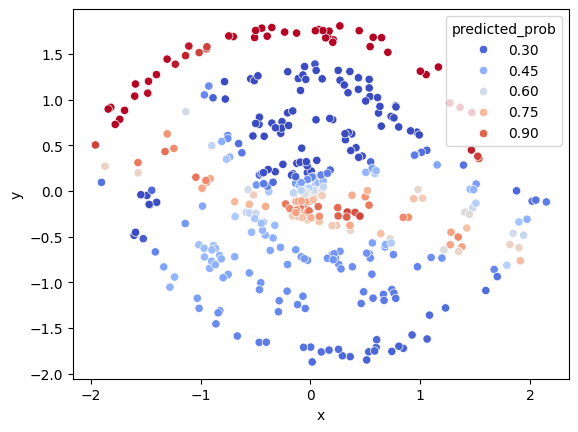

In [324]:
# Make sure the model is in evaluation mode
model.eval()

# Prepare the input data from the dataframe (assumes 'x' and 'y' are the input features)
inputs = torch.tensor(df[['x', 'y']].values, dtype=torch.float32)

# Get predictions (model outputs probabilities)
with torch.no_grad():
    pred_probs = model(inputs)

# Convert predicted probabilities to a numpy array and add them as a new column to the dataframe
df['predicted_prob'] = pred_probs.numpy()

# Check the updated dataframe
sns.scatterplot(data=df, x='x', y='y', hue='predicted_prob', palette="coolwarm")
print(f"Val Acc: {val_acc:.2%}")


As a reminder, here are the **hyperparameters** you can tune to try and improve your Neural Network. 

Play around with any and all of these to see what seems to work best!

- Number of hidden layers in the NN
- Number of neurons in each layer of the NN
- Activation function at each layer in the NN
- Whether or not you need regularization (dropout) to mitigate overfitting
- If so, what proportion of neurons should you drop out after each layer?
- Number of epochs
- Batch size
- Learning rate